# 0. Intro

- PyTorch의 Tensor를 이용하여 Image plot
- PyTorch를 이용하여 다양한 이미지 분류 모델을 생성
- 다양한 모델 학습 방법 사용
- 다양한 모델 평가 방법 사용
- 모델 성능 높이기

In [40]:
# import library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# kernel dead 방지
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# visualization
import matplotlib.pyplot as plt
import numpy as np

# 1. Data

## 1.1  Data Read
PyTorch를 이용하여 CIFAR-10 데이터를 불러온다.

In [5]:
# torchvision 데이터 셋의 output은 [0,1]범위를 가지는 PILImage 이미지
# 이를 [-1,1] 범위로 정규화된 Tensor로 변환
# image 3 chanel, mean : [0.5, 0.5, 0.5], std : [0.5, 0.5, 0.5]
# output[channel] = (input[channel] - mean[channel]) / std[channel]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 10,
                                          shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                        download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 10,
                                          shuffle = True, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 1.2 Data Visualization

In [31]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (10,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

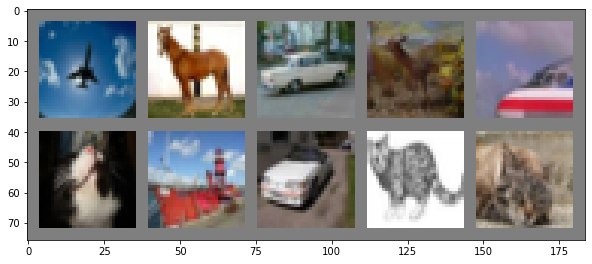

plane horse   car  deer plane   cat  ship   car   cat   cat


In [32]:
# 학습용 랜덤 이미지 - original image
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow = 5, padding = 4, pad_value = 0))

print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [33]:
# torch로 시각화한 image 데이터 저장하기
torchvision.utils.save_image(images, fp = './train_random_img.jpg', nrow = 5, padding = 4)

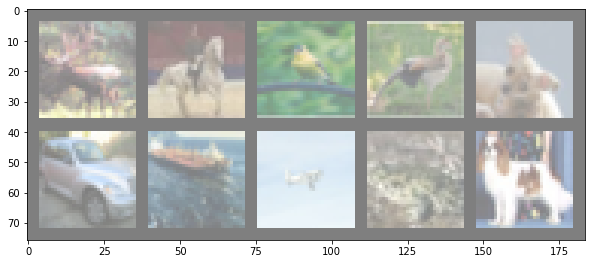

 deer horse  bird  bird   dog   car  ship plane  frog   dog


In [34]:
# 학습용 랜덤 이미지 - normalize image
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow = 5, padding = 4, pad_value = 0, normalize = True))

print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

## 1.3 Data Augmentations
Albumentations 라이브러리를 사용하여 data augmentation 진행
- https://hoya012.github.io/blog/albumentation_tutorial/

# 2. Model Define

## 2.1 Basic CNN

In [46]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # 신경망 재료 구성하기
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # 실제 데이터와 엮기
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 2.2 Deep Basic CNN

In [47]:
class DeepBasicCNN(nn.Module):
    def __init__(self):
        super(DeepBasicCNN, self).__init__()
        # 신경망 재료 구성하기
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 640)
        self.fc2 = nn.Linear(640, 320)
        self.fc3 = nn.Linear(320, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 40)
        self.fc6 = nn.Linear(40, 10)
        
    def forward(self, x):
        # 실제 데이터와 엮기
        x = F.relu(self.conv1(x)) # 30 by 30
        x = self.pool(F.relu(self.conv2(x))) # 14 by 14
        x = F.relu(self.conv3(x)) # 12 by 12
        x = self.pool(F.relu(self.conv4(x))) # 5 by 5
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# 3. Loss Function and Optimizer Define

In [48]:
deep_net = DeepBasicCNN()

cross_entropy = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(deep_net.parameters(), lr = 0.001, momentum = 0.9)

In [51]:
for epoch in range(50):
    running_loss = 0.0
    
    # minibatch -> trainloader의 batch_size가 4로 설정
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # 한번 mini-batch학습 수행할 때 마다 초기화
        # 4-data 1-train
        sgd_optimizer.zero_grad()
        
        outputs = deep_net(inputs)
        loss = cross_entropy(outputs, labels)
        loss.backward()
        sgd_optimizer.step()
        
        # 통계정보 요약
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
print('Finished Training')

[1,  2000] loss : 1.686
[1,  4000] loss : 1.610
[2,  2000] loss : 1.467
[2,  4000] loss : 1.389
[3,  2000] loss : 1.261
[3,  4000] loss : 1.211
[4,  2000] loss : 1.098
[4,  4000] loss : 1.053
[5,  2000] loss : 0.946
[5,  4000] loss : 0.929
[6,  2000] loss : 0.815
[6,  4000] loss : 0.814
[7,  2000] loss : 0.670
[7,  4000] loss : 0.701
[8,  2000] loss : 0.552
[8,  4000] loss : 0.591
[9,  2000] loss : 0.441
[9,  4000] loss : 0.483
[10,  2000] loss : 0.336
[10,  4000] loss : 0.401
[11,  2000] loss : 0.283
[11,  4000] loss : 0.318
[12,  2000] loss : 0.209
[12,  4000] loss : 0.253
[13,  2000] loss : 0.174
[13,  4000] loss : 0.219
[14,  2000] loss : 0.141
[14,  4000] loss : 0.170
[15,  2000] loss : 0.114
[15,  4000] loss : 0.135
[16,  2000] loss : 0.089
[16,  4000] loss : 0.134
[17,  2000] loss : 0.081
[17,  4000] loss : 0.105
[18,  2000] loss : 0.077
[18,  4000] loss : 0.092
[19,  2000] loss : 0.054
[19,  4000] loss : 0.080
[20,  2000] loss : 0.054
[20,  4000] loss : 0.072
[21,  2000] loss :